<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li><li><span><a href="#-Комментарий-ревьюера" data-toc-modified-id="-Комментарий-ревьюера-5"><span class="toc-item-num">5&nbsp;&nbsp;</span> Комментарий ревьюера</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import re
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#загрузим данные
df = pd.read_csv("/datasets/toxic_comments.csv")
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
#посмотрим информацию о ДФ
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


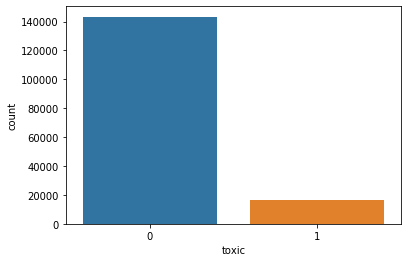

In [4]:
#посмотрим на количество токсичных и нет файлов
sns.countplot(x="toxic", data=df)

Мы видим что нетоксичных слов во много раз больше чем токсичных

In [5]:
#уберем знаки препинания
def no_punct(text):
    text = "".join([i for i in text if i not in string.punctuation])
    text = re.sub("[0-9]+", "", text)
    return text
df["punctuation"] = df["text"].apply(lambda x: no_punct(x))
df.head()

,text,toxic,punctuation
0,Explanation\nWhy the edits made under my usern...,0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...,0,Daww He matches this background colour Im seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man Im really not trying to edit war Its j...
3,"""\nMore\nI can't make any real suggestions on ...",0,\nMore\nI cant make any real suggestions on im...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...


In [6]:
#проведем токенизацию
def tokenization(text):
    text = re.split("\W+", text)
    return text
df["tokenize"] = df["punctuation"].apply(lambda x: tokenization(x.lower()))
df.head()

,text,toxic,punctuation,tokenize
0,Explanation\nWhy the edits made under my usern...,0,Explanation\nWhy the edits made under my usern...,"[explanation, why, the, edits, made, under, my..."
1,D'aww! He matches this background colour I'm s...,0,Daww He matches this background colour Im seem...,"[daww, he, matches, this, background, colour, ..."
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man Im really not trying to edit war Its j...,"[hey, man, im, really, not, trying, to, edit, ..."
3,"""\nMore\nI can't make any real suggestions on ...",0,\nMore\nI cant make any real suggestions on im...,"[, more, i, cant, make, any, real, suggestions..."
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,"[you, sir, are, my, hero, any, chance, you, re..."


In [7]:
#удалим стоп-слова
stopword = nltk.corpus.stopwords.words('english')
def stop_words(text):
    text = [i for i in text if i not in stopword]
    return text
df["stopwords"] = df["tokenize"].apply(lambda x: stop_words(x))
df.head()

,text,toxic,punctuation,tokenize,stopwords
0,Explanation\nWhy the edits made under my usern...,0,Explanation\nWhy the edits made under my usern...,"[explanation, why, the, edits, made, under, my...","[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,0,Daww He matches this background colour Im seem...,"[daww, he, matches, this, background, colour, ...","[daww, matches, background, colour, im, seemin..."
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man Im really not trying to edit war Its j...,"[hey, man, im, really, not, trying, to, edit, ...","[hey, man, im, really, trying, edit, war, guy,..."
3,"""\nMore\nI can't make any real suggestions on ...",0,\nMore\nI cant make any real suggestions on im...,"[, more, i, cant, make, any, real, suggestions...","[, cant, make, real, suggestions, improvement,..."
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,"[you, sir, are, my, hero, any, chance, you, re...","[sir, hero, chance, remember, page, thats]"


In [8]:
#лемитизация
wn = nltk.WordNetLemmatizer()

def limitization(text):
    text = [wn.lemmatize(word) for word in text]
    return text

df['lemmatized'] = df['stopwords'].apply(lambda x: limitization(x))
df.head()

,text,toxic,punctuation,tokenize,stopwords,lemmatized
0,Explanation\nWhy the edits made under my usern...,0,Explanation\nWhy the edits made under my usern...,"[explanation, why, the, edits, made, under, my...","[explanation, edits, made, username, hardcore,...","[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,0,Daww He matches this background colour Im seem...,"[daww, he, matches, this, background, colour, ...","[daww, matches, background, colour, im, seemin...","[daww, match, background, colour, im, seemingl..."
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man Im really not trying to edit war Its j...,"[hey, man, im, really, not, trying, to, edit, ...","[hey, man, im, really, trying, edit, war, guy,...","[hey, man, im, really, trying, edit, war, guy,..."
3,"""\nMore\nI can't make any real suggestions on ...",0,\nMore\nI cant make any real suggestions on im...,"[, more, i, cant, make, any, real, suggestions...","[, cant, make, real, suggestions, improvement,...","[, cant, make, real, suggestion, improvement, ..."
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,"[you, sir, are, my, hero, any, chance, you, re...","[sir, hero, chance, remember, page, thats]","[sir, hero, chance, remember, page, thats]"


### Вывод:
> Мы загрузили наш ДФ, он состоит из 2 столбцов и 159571 строк. Видим что нетоксичных комментариев намного больше чем токсичных. Провели лемитизацию, токенизациб, удалил стоп-слова, убрали знаки препинания

## Обучение

In [9]:
#поледим наши данные на обучающую и тестовую выборки
train, test = train_test_split(df, test_size=0.3, random_state=12345)

In [10]:
count_tf_idf = TfidfVectorizer()

In [11]:
#зададим наши модели и их параметры 
models = {
    "LogisticRegression" : LogisticRegression(),
    'LGBMClassifier': lgb.LGBMClassifier()     
}
params = {
    'LogisticRegression':{
          'class_weight':['balanced', None],
          'C':[1,10,100]
    },        
    'LGBMClassifier': {
        'boosting_type':['gbdt'],
        'objective':['binary'],
        'learning_rate':[0.02,0.05],
        'num_iterations':[500],
        'num_leaves':[50,75],
        'feature_fraction':[0.64,0.8],
        'bagging_fraction':[0.8,0.9],
        'bagging_freq':[1,2]
        }
}

In [14]:
#выделим признаки и целевой признак
features = ["text", "punctuation", "tokenize", "stopwords", "lemmatized"]

for feature in features:
    X_train = train[feature]
    y_train = train["toxic"]
    X_test = test[feature]
    y_test = test["toxic"]
    
    train_corpus = X_train.astype("U")
    tfidf_train = count_tf_idf.fit_transform(train_corpus)
    
    corpus_test = X_test.astype('U')
    tfidf_test = count_tf_idf.transform(corpus_test)
    

In [ ]:
#напишем функцию для обучения моделей
# def fit_predict(X_train, y_train, X_test, y_test):
#         for name in models.keys():
#             est = models[name]
#             est_params = params[name]
#             gscv = GridSearchCV(estimator=est, param_grid=est_params, cv=5, n_jobs=-1,verbose=0)
#             gscv.fit(X_train, y_train)     
#             predictions = gscv.predict(X_test)
#             result_list.append({
#             'model': name,
#             'feature': feature,
#             'f1_score': f1_score(y_test, predictions),
#             'best_params': gscv.best_estimator_
#             })

In [ ]:
# result_list = []
# fit_predict(tfidf_train, y_train, tfidf_test, y_test)

**Логистическая регрессия**

In [15]:
lg_model = LogisticRegression()

In [16]:
lg_param_searth = {'class_weight':['balanced', None], 'C':[1,10,100]}

In [17]:
lg_gscv = GridSearchCV(estimator=lg_model, param_grid=lg_param_searth, cv=5, n_jobs=-1,verbose=0)
lg_gscv.fit(tfidf_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [1, 10, 100], 'class_weight': ['balanced', None]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [18]:
lg_gscv.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
lg_model_best = LogisticRegression(C=10, class_weight=None, random_state=12345)

In [20]:
lg_model_best.fit(tfidf_train, y_train)
lg_predictions = lg_model_best.predict(tfidf_test)
print("F1_score:", f1_score(y_test, lg_predictions))

F1_score: 0.7865832859579306


## Выводы

Мы подобрали наилучшие параметры для модели Логистической регрессии и обучили модель. F1_score получился 0.78 что соответствует нашим условиям